In [1]:
%matplotlib inline
import os
import sys
from glob import glob

import numpy as np
import pandas as pd
idx = pd.IndexSlice
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import copy

import geopandas as gpd

from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import gpflow
import tensorflow as tf

code_dir = '/cluster/home/kheuto01/code/zero-inflated-gp/'
sys.path.append(code_dir)

from onoffgpf import OnOffSVGP, OnOffLikelihood

import pickle

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cluster/tufts/hugheslab/kheuto01/miniconda3/envs/zigp_36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_q

In [2]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/'
result_dir = os.path.join(data_dir, 'results')
mass_shapefile = os.path.join(data_dir,'shapefiles','MA_2021')

In [3]:


svi_file = os.path.join(result_dir,'svi_qtr')
svi_gdf = gpd.read_file(svi_file)
svi_gdf = svi_gdf.rename(columns={'INTPTLAT':'lat', 'INTPTLON':'lon', 'GEOID':'grid_squar'})
# Make lat and lon floats
svi_gdf.loc[:, 'lat'] = svi_gdf.lat.astype(float)
svi_gdf.loc[:, 'lon'] = svi_gdf.lon.astype(float)
deaths_gdf = svi_gdf



In [4]:
just_grid = deaths_gdf.loc[(deaths_gdf['year']==2000)&(deaths_gdf['quarter']==4), ['grid_squar','geometry', 'lat', 'lon']]


In [5]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    https://stackoverflow.com/a/4913653/1748679
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [7]:
# Calculate each squares neighbors
neighbors = {}
for _, row in just_grid.iterrows():
    just_grid.loc[:,'haversine'] = just_grid.apply(lambda x: haversine(row['lon'], row['lat'],
                                                                         x['lon'], x['lat']),
                                                  axis=1)
    matching_neighbors = just_grid[just_grid['haversine']<8]['grid_squar'].values
    neighbors[row['grid_squar']]=matching_neighbors

In [8]:
tracts = deaths_gdf['grid_squar'].unique()
min_year = deaths_gdf.year.min()
max_year = deaths_gdf.year.max()

In [9]:
deaths_gdf = deaths_gdf.set_index(['grid_squar','year','quarter']).sort_index()

In [10]:
deaths_gdf.loc[idx[:,:,:],'self_t-1'] = deaths_gdf.loc[idx[:,:,:],'deaths'].shift(1, fill_value=0)

In [11]:
for tract in tracts:
     deaths_gdf.loc[idx[tract,:,:],'neighbor_t-1']= \
        deaths_gdf.loc[idx[neighbors[tract],:,:],'self_t-1'].groupby(level=['year', 'quarter']).mean().shift(1, fill_value=0).values

In [12]:
timestep = 0

for year in range(min_year, max_year+1):
    for quarter in range(1, 5):
        deaths_gdf.loc[idx[:,year, quarter], 'timestep'] = timestep
        timestep+=1

In [13]:
deaths_gdf_with_autoregressive = deaths_gdf.reset_index()

In [14]:
train_x_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2018 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2018][['grid_squar',  'timestep', 'deaths']]
train_x_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
train_y_through_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']<=2019][['grid_squar', 'timestep', 'deaths']]

x_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2019][['grid_squar','timestep', 'deaths']]
x_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']]
y_just_2020 = deaths_gdf_with_autoregressive[deaths_gdf_with_autoregressive['year']==2020][['grid_squar', 'timestep', 'deaths']]

x_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','lat', 'lon', 'timestep', 'theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile','neighbor_t-1', 'self_t-1']]
y_just_2019q1 = deaths_gdf_with_autoregressive[(deaths_gdf_with_autoregressive['year']==2019) & (deaths_gdf_with_autoregressive['quarter']==1)][['grid_squar','timestep', 'deaths']]


In [15]:
with open('/cluster/home/kheuto01/test/model.pkl','rb') as f:
    model = pickle.load(f)

In [16]:
_gfmean,_gfvar,_,_fmean,_fvar,_gmean,_gvar,_pgmean,_pgvar = model.predict_onoffgp(x_just_2019q1.loc[:, ['lat','lon','timestep','theme_1_pc', 'theme_2_pc', 'theme_3_pc', 'theme_4_pc', 'svi_pctile', 'neighbor_t-1', 'self_t-1']].values)

In [17]:
_u_fm = model.u_fm.value
_u_gm = model.u_gm.value

In [18]:
pred_df = pd.Series(_gfmean.squeeze(), index=x_just_2019q1.grid_squar)
f_df = pd.Series(_fmean.squeeze(), index=x_just_2019q1.grid_squar)
f_given_g_df = pd.Series(_gfmean.squeeze(), index=x_just_2019q1.grid_squar)
probit_g_df =pd.Series(_pgmean.squeeze(), index=x_just_2019q1.grid_squar)

deaths_and_pred = y_just_2019.merge(pred_df.rename('pred_death'),left_on='grid_squar', right_index=True)
deaths_and_f = y_just_2019.merge(f_df.rename('f_mean'),left_on='grid_squar', right_index=True)
deaths_and_fg = y_just_2019.merge(f_given_g_df.rename('fg_mean'),left_on='grid_squar', right_index=True)
deaths_and_pg = y_just_2019.merge(probit_g_df.rename('pg_mean'),left_on='grid_squar', right_index=True)


pred_gdf  = just_grid.merge(deaths_and_pred, on='grid_squar')
f_gdf  = just_grid.merge(deaths_and_f, on='grid_squar')
fg_gdf  = just_grid.merge(deaths_and_fg, on='grid_squar')
pg_gdf  = just_grid.merge(deaths_and_pg, on='grid_squar')

Text(68.375, 0.5, 'Latitude')

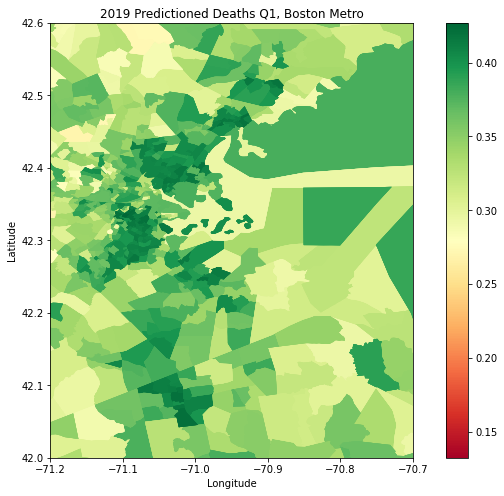

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
f_gdf.plot(column='f_mean', cmap='RdYlGn',ax=ax, legend=True)
plt.title(f'2019 Predictioned Deaths Q1, Boston Metro')
plt.xlim([-71.2, -70.7])
plt.xlabel('Longitude')
plt.ylim([42, 42.6])
plt.ylabel('Latitude')

(42.0, 42.6)

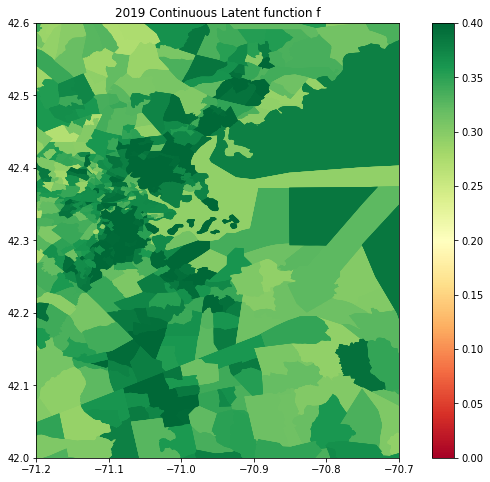

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
f_gdf.plot(column='f_mean', cmap='RdYlGn',ax=ax, legend=True,
                 vmin=0, vmax=0.4)
plt.title(f'2019 Continuous Latent function f')
plt.xlim([-71.2, -70.7])
plt.ylim([42, 42.6])

(42.0, 42.6)

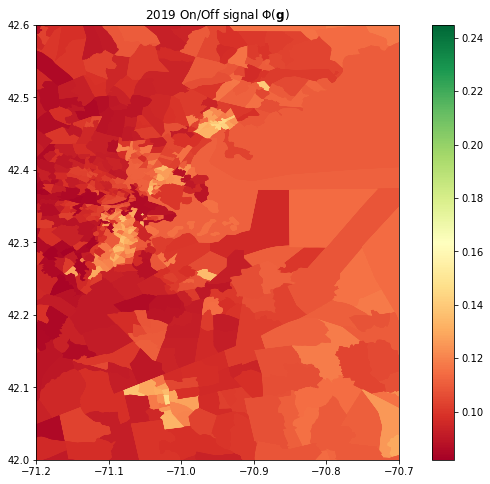

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
pg_gdf.plot(column='pg_mean', cmap='RdYlGn',ax=ax, legend=True,)
                 #vmin=-20, vmax=20)
plt.title(f'2019 On/Off signal ' +r"$\Phi(\mathbf{g})$")
plt.xlim([-71.2, -70.7])
plt.ylim([42, 42.6])

(42.0, 42.6)

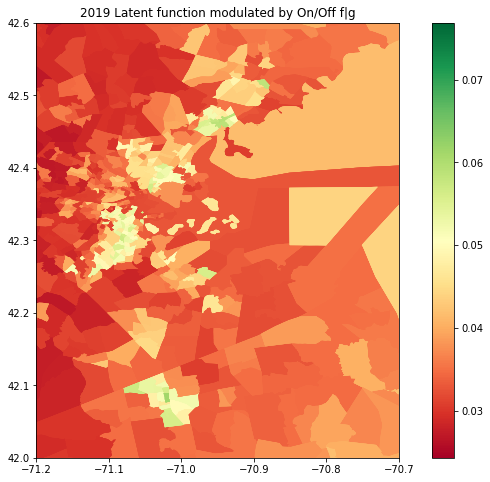

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
fg_gdf.plot(column='fg_mean', cmap='RdYlGn',ax=ax, legend=True,)
                 #vmin=-20, vmax=20)
plt.title(f'2019 Latent function modulated by On/Off f|g')
plt.xlim([-71.2, -70.7])
plt.ylim([42, 42.6])